In [1]:
import os
os.chdir('..')

In [3]:
import torch
import numpy as np
from gnn_library.util import load
from evaluate import evaluate_model
from instance_generator import sample_instances
from params import *
from util import _box_plots

%load_ext autoreload
%autoreload 2

In [7]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

models = {
	'GENConv': load('GNN_large_10_6', device),
	'DeeperGCN': load('other_GNN_deeperGCN', device),
	'GATv2Conv': load('other_GNN_Gatv2Conv', device),
	'GraphConv': load('other_GNN_GraphConv', device),
	'GCNConv': load('other_GNN_GCNConv', device),

}
_, args = load('GNN_large_10_6', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:4


## Box plot baseline evaluation

#### Evaluate CRs on all graph configurations

In [23]:
import pickle # TODO remove

rng = np.random.default_rng()
num_trials = 150
batch_size = 500
node_configs = [(20, 10)]
graph_configs = MAIN_TESTING_GRAPH_CONFIGS
baselines_kwargs = {
    # 'greedy': {},
    # 'greedy_t': {'threshold': 0.35},
    # 'lp_rounding': {'rng': rng},
    # 'naor_lp_rounding': {'rng': rng},
    # 'pollner_lp_rounding': {'rng': rng}
}

data = {node_config: {str(graph_config): {} for graph_config in graph_configs} for node_config in node_configs}

for node_config in node_configs:
    for graph_config in graph_configs:
            print(node_config, graph_config)
            instances = sample_instances(
                *node_config,
                num_trials,
                rng,
                args.__dict__,
                **graph_config
            )
            for model_name, (GNN, args) in models.items():
                print(model_name)
                cr_ratios, _ = evaluate_model(
                    meta_model=None,
                    meta_model_type=None,
                    base_models=[GNN],
                    instances=instances,
                    batch_size=batch_size,
                    rng=rng,
                    num_realizations=20,
                    baselines=[],
                    **baselines_kwargs
                )

                data[node_config][str(graph_config)][model_name] = cr_ratios['learned']

            with open(f"experiments/box_plots_main.pickle", 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


(20, 10) {'graph_type': 'ER', 'p': 0.5, 'weighted': True}
GENConv


/home/alexhay/GNN-OBM/torch_converter.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mask)


DeeperGCN
GATv2Conv
GraphConv
GCNConv
(20, 10) {'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True}
GENConv
DeeperGCN
GATv2Conv
GraphConv
GCNConv


#### Generate box plots

{'graph_type': 'ER', 'p': 0.5, 'weighted': True} {'GENConv': [0.9185142997274282, 0.9611533413308649, 0.9536107226602752], 'DeeperGCN': [0.9300626850323509, 0.9652262500637667, 0.9331918649744531], 'GATv2Conv': [0.8137965287610752, 0.9426284375771763, 0.8998307498993322], 'GraphConv': [0.9172552202176719, 0.947313324888232, 0.9527292886297918], 'GCNConv': [0.8007285518810472, 0.8532359605495493, 0.8018080200872385]}
{'graph_type': 'GEOM', 'q': 0.25, 'd': 2, 'weighted': True} {'GENConv': [0.9615918322509268, 0.9683274477698056, 0.9483649350284292], 'DeeperGCN': [0.9330317793186721, 0.9743678716166466, 0.9667679991734337], 'GATv2Conv': [0.948112707397452, 0.9594410352345524, 0.9558033611866007], 'GraphConv': [0.949227516996588, 0.9860343275194161, 0.9438872813267614], 'GCNConv': [0.927968033486972, 0.8485361635637215, 0.9503907321338971]}
{'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'} {'GENConv': [0.9739324021852557, 0.9581608701308868, 0.9641006883084315], 'DeeperGCN': 

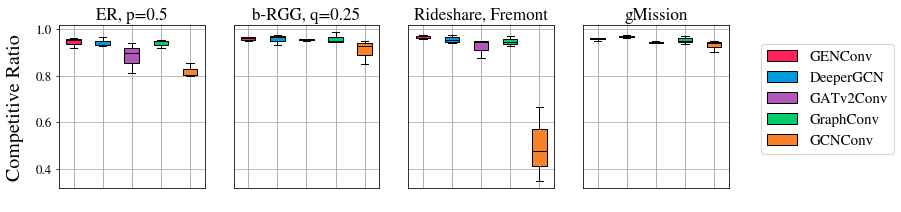

In [22]:
results = {}
for graph_type, val in data[node_configs[0]].items():
	results[graph_type] = val
	print(f"{graph_type} {val}")

_box_plots(results, lambda graph_type: f"GNN2_classify_{graph_type} {node_config[1]}x{node_config[0]}")

In [30]:
for label in ['learned', 'greedy', 'greedy_t', 'lp_rounding', 'naor_lp_rounding', 'pollner_lp_rounding']:
    print(label)
    print(np.nanmean(results["{'graph_type': 'ER', 'p': 0.5, 'weighted': True}"][label]))
    print(np.nanstd(results["{'graph_type': 'ER', 'p': 0.5, 'weighted': True}"][label]))
    print(np.nanmax(results["{'graph_type': 'ER', 'p': 0.5, 'weighted': True}"][label]))
    print(np.nanmin(results["{'graph_type': 'ER', 'p': 0.5, 'weighted': True}"][label]))
    print()

learned
0.9375406822946877
0.020488721688707814
0.9770632668156484
0.8906075746635768

greedy
0.8832660468014378
0.042111343516759936
0.9695886660041662
0.773918419580194

greedy_t
0.8943132303877158
0.034755100745926415
0.9634036702937727
0.8235931314200542

lp_rounding
0.9160779507565222
0.021609797545870682
0.9605348860405354
0.8639270548190373

naor_lp_rounding
0.9138430650193456
0.021827750625309453
0.9597701078420974
0.859539364718328

pollner_lp_rounding
0.9200531820781406
0.019780583620047858
0.9602326865163937
0.8708671887402302

